In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=a0dcaa1a2919ab9f56cdd1238eca6df2bf7a0e115f125ad6c9cdff8910e9c1b9
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
!pip install plotly

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when, greatest
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType, ArrayType, StringType
from pyspark.ml.evaluation import ClusteringEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import plotly.express as px

In [ ]:
spark = SparkSession.builder.appName("KMeansTanaman").getOrCreate()

In [ ]:
df = spark.read.option("header", "true").csv('data.csv')
header = df.take(3)

df = df.filter(df['_c0'] != header[0][0])

df.show(5)

+--------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|           _c0|  _c1|  _c2|  _c3|  _c4|  _c5|  _c6|  _c7|  _c8|  _c9|
+--------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|          Aceh|56.21|67.87|64.53|47.35|57.72|54.83|40.72|52.51|48.83|
|Sumatera Utara|43.58|55.91|49.92|35.23|40.07|37.72|36.09|46.53|41.14|
|Sumatera Barat|51.84|61.36|57.71|42.59|52.33|48.59|46.34|54.59|51.17|
|          Riau|57.23|71.49|66.08|43.09|65.31|56.76|42.53|66.09|56.66|
|         Jambi|37.28|62.59|55.44|37.87|52.59|48.26|39.43|59.49|53.46|
+--------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
only showing top 5 rows



In [ ]:
years = ["2019", "2020", "2021"]
locations = ["kota", "desa", "kota_dan_desa"]

for index, (year, location) in enumerate(itertools.product(years, locations), start=1):
    old_col = f"_c{index}"
    new_col = f"{location}-{year}"
    df = df.withColumnRenamed(old_col, new_col)

df = df.withColumnRenamed('_c0', 'provinsi')
df.show(5)

+--------------+---------+---------+------------------+---------+---------+------------------+---------+---------+------------------+
|      provinsi|kota-2019|desa-2019|kota_dan_desa-2019|kota-2020|desa-2020|kota_dan_desa-2020|kota-2021|desa-2021|kota_dan_desa-2021|
+--------------+---------+---------+------------------+---------+---------+------------------+---------+---------+------------------+
|          Aceh|    56.21|    67.87|             64.53|    47.35|    57.72|             54.83|    40.72|    52.51|             48.83|
|Sumatera Utara|    43.58|    55.91|             49.92|    35.23|    40.07|             37.72|    36.09|    46.53|             41.14|
|Sumatera Barat|    51.84|    61.36|             57.71|    42.59|    52.33|             48.59|    46.34|    54.59|             51.17|
|          Riau|    57.23|    71.49|             66.08|    43.09|    65.31|             56.76|    42.53|    66.09|             56.66|
|         Jambi|    37.28|    62.59|             55.44|    37.

In [ ]:
df.printSchema()

root
 |-- provinsi: string (nullable = true)
 |-- kota-2019: string (nullable = true)
 |-- desa-2019: string (nullable = true)
 |-- kota_dan_desa-2019: string (nullable = true)
 |-- kota-2020: string (nullable = true)
 |-- desa-2020: string (nullable = true)
 |-- kota_dan_desa-2020: string (nullable = true)
 |-- kota-2021: string (nullable = true)
 |-- desa-2021: string (nullable = true)
 |-- kota_dan_desa-2021: string (nullable = true)



In [ ]:
df = df.replace(0, None)

selected_columns = df.columns[1:]

for col_name in selected_columns:
    df = df.withColumn(col_name, df[col_name].cast("double"))

# Calculate mean values
mean_values = df.agg(*(mean(column).alias(column) for column in df.columns)).collect()[0].asDict()

# Replace missing values with mean
for column in df.columns:
    df = df.withColumn(column, when(df[column].isNull(), mean_values[column]).otherwise(df[column]))
df.show()

+--------------------+---------+---------+------------------+---------+---------+------------------+---------+---------+------------------+
|            provinsi|kota-2019|desa-2019|kota_dan_desa-2019|kota-2020|desa-2020|kota_dan_desa-2020|kota-2021|desa-2021|kota_dan_desa-2021|
+--------------------+---------+---------+------------------+---------+---------+------------------+---------+---------+------------------+
|                Aceh|    56.21|    67.87|             64.53|    47.35|    57.72|             54.83|    40.72|    52.51|             48.83|
|      Sumatera Utara|    43.58|    55.91|             49.92|    35.23|    40.07|             37.72|    36.09|    46.53|             41.14|
|      Sumatera Barat|    51.84|    61.36|             57.71|    42.59|    52.33|             48.59|    46.34|    54.59|             51.17|
|                Riau|    57.23|    71.49|             66.08|    43.09|    65.31|             56.76|    42.53|    66.09|             56.66|
|               Jamb

In [ ]:
df_clustering = df.select(selected_columns + ["provinsi"])
vec_assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
final_data = vec_assembler.transform(df_clustering)
final_data.select('provinsi','features').show(5)

+--------------+--------------------+
|      provinsi|            features|
+--------------+--------------------+
|          Aceh|[56.21,67.87,64.5...|
|Sumatera Utara|[43.58,55.91,49.9...|
|Sumatera Barat|[51.84,61.36,57.7...|
|          Riau|[57.23,71.49,66.0...|
|         Jambi|[37.28,62.59,55.4...|
+--------------+--------------------+
only showing top 5 rows



In [ ]:
scaler = StandardScaler(inputCol="features",  outputCol="scaledFeatures",  withStd=True,  withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

final_data.select('provinsi', 'features' ,'scaledFeatures').show()

+--------------------+--------------------+--------------------+
|            provinsi|            features|      scaledFeatures|
+--------------------+--------------------+--------------------+
|                Aceh|[56.21,67.87,64.5...|[5.73152396894816...|
|      Sumatera Utara|[43.58,55.91,49.9...|[4.44368999407153...|
|      Sumatera Barat|[51.84,61.36,57.7...|[5.28593137431547...|
|                Riau|[57.23,71.49,66.0...|[5.83552956311872...|
|               Jambi|[37.28,62.59,55.4...|[3.80130250066514...|
|    Sumatera Selatan|[42.28,64.83,57.1...|[4.31113384463847...|
|            Bengkulu|[58.15,67.66,64.8...|[5.92933853040981...|
|             Lampung|[42.15,75.76,67.5...|[4.29787822969516...|
|Kepulauan Bangka ...|[57.86,63.17,60.6...|[5.89976831245936...|
|      Kepulauan Riau|[41.43,44.98,42.0...|[4.22446251616300...|
|         DKI Jakarta|[15.88,63.17,15.8...|[1.61922434845929...|
|          Jawa Barat|[33.68,50.96,39.7...|[3.43422393300434...|
|         Jawa Tengah|[50

In [ ]:
silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    model=kmeans.fit(final_data)
    predictions=model.transform(final_data)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.4799317517758629
Silhouette Score for k = 3 is 0.47655116546184145
Silhouette Score for k = 4 is 0.39724353764773207
Silhouette Score for k = 5 is 0.3990413219985106
Silhouette Score for k = 6 is 0.37833762780098495
Silhouette Score for k = 7 is 0.34485448038655525
Silhouette Score for k = 8 is 0.14200128890193622
Silhouette Score for k = 9 is 0.20564215477928396


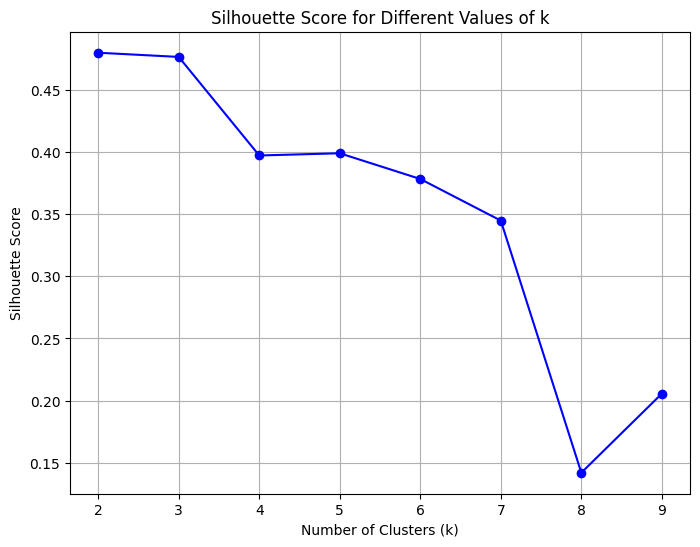

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_score, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=8)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

# Printing cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
	print(center)

Cluster Centers: 
[5.3393617  8.111038   5.72659675 5.01469657 6.79967872 5.54089322
 4.88825466 6.64750802 4.99895497]
[1.61922435 7.55424573 1.45634189 1.54949776 6.66473943 1.37463939
 1.11361387 5.74342606 0.89737896]
[4.17144006 6.49163896 4.40007577 4.05897133 4.91677196 3.86082514
 3.32547158 4.49803762 3.12231185]
[4.35701867 7.17396234 3.8682935  3.09670674 6.80778859 4.81326836
 2.97037644 5.6245385  3.36070208]
[4.6480304  7.94218261 5.49869942 4.18066854 6.43811351 5.11601391
 3.80115013 6.18909656 4.43255153]
[ 5.25942014 10.43268002  5.7859326   5.59375556  9.27003642  6.04374321
  5.27635575  8.20113686  4.96239839]
[6.73283273 8.71422964 6.42927254 6.13276106 7.27635908 6.08384532
 5.73832804 6.12744337 5.09825656]
[4.13830102 7.16693667 4.77976818 3.860727   5.82657833 4.54054864
 4.08759513 5.95858096 4.32601013]


In [ ]:
predictions.select('provinsi', 'features', 'prediction').show(30)

+--------------------+--------------------+----------+
|            provinsi|            features|prediction|
+--------------------+--------------------+----------+
|                Aceh|[56.21,67.87,64.5...|         0|
|      Sumatera Utara|[43.58,55.91,49.9...|         2|
|      Sumatera Barat|[51.84,61.36,57.7...|         0|
|                Riau|[57.23,71.49,66.0...|         0|
|               Jambi|[37.28,62.59,55.4...|         7|
|    Sumatera Selatan|[42.28,64.83,57.1...|         7|
|            Bengkulu|[58.15,67.66,64.8...|         0|
|             Lampung|[42.15,75.76,67.5...|         0|
|Kepulauan Bangka ...|[57.86,63.17,60.6...|         0|
|      Kepulauan Riau|[41.43,44.98,42.0...|         2|
|         DKI Jakarta|[15.88,63.17,15.8...|         1|
|          Jawa Barat|[33.68,50.96,39.7...|         2|
|         Jawa Tengah|[50.97,63.92,58.0...|         0|
|       DI Yogyakarta|[51.58,87.24,63.0...|         5|
|          Jawa Timur|[43.74,66.44,55.8...|         0|
|         

In [ ]:
df_result = predictions.withColumn("avg_kota", (F.col("kota-2019") + F.col("kota-2020") + F.col("kota-2021")) / 3).withColumn("avg_desa",(F.col("desa-2019") + F.col("desa-2020") + F.col("desa-2021")) / 3).select("provinsi","avg_kota", "avg_desa", "prediction", "kota-2019", "kota-2020", "kota-2021", "desa-2019", "desa-2020", "desa-2021")
avg_growth_by_cluster = (
    df_result
    .groupBy("prediction")
    .agg(
        F.mean("kota-2019").alias("avg_tanaman_dikota_2019"),
        F.mean("kota-2020").alias("avg_tanaman_dikota_2020"),
        F.mean("kota-2021").alias("avg_tanaman_dikota_2021"),
        F.mean("desa-2019").alias("avg_tanaman_didesa_2019"),
        F.mean("desa-2020").alias("avg_tanaman_didesa_2020"),
        F.mean("desa-2021").alias("avg_tanaman_didesa_2021"),
    )
)

avg_growth_by_cluster.show()

avg_kota_and_desa_by_prediction = avg_growth_by_cluster.withColumn(
    "avg_kota",
    (F.col("avg_tanaman_dikota_2019") + F.col("avg_tanaman_dikota_2020") + F.col("avg_tanaman_dikota_2021")) / 3
).withColumn(
    "avg_desa",
    (F.col("avg_tanaman_didesa_2019") + F.col("avg_tanaman_didesa_2020") + F.col("avg_tanaman_didesa_2021")) / 3
).select('prediction', 'avg_kota', 'avg_desa')

avg_kota_and_desa_by_prediction.show()

avg_kota_value = (avg_kota_and_desa_by_prediction.select("avg_kota").collect()[0][0] + avg_kota_and_desa_by_prediction.select("avg_kota").collect()[1][0] + avg_kota_and_desa_by_prediction.select("avg_kota").collect()[2][0])
avg_desa_value = (avg_kota_and_desa_by_prediction.select("avg_desa").collect()[0][0] + avg_kota_and_desa_by_prediction.select("avg_desa").collect()[1][0] + avg_kota_and_desa_by_prediction.select("avg_desa").collect()[2][0])
kodes_terhijau = "Kota" if avg_kota_value > avg_desa_value else "Desa"

print(f"Banyak tanaman dikota: {avg_kota_value / 3}")
print(f"Banyak tanaman didesa: {avg_desa_value / 3}")
print(f"Adalah di: {kodes_terhijau}")

+----------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|prediction|avg_tanaman_dikota_2019|avg_tanaman_dikota_2020|avg_tanaman_dikota_2021|avg_tanaman_didesa_2019|avg_tanaman_didesa_2020|avg_tanaman_didesa_2021|
+----------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|         1|                  15.88|                  13.54|                  10.04|                  63.17|                  59.17|                  54.59|
|         6|                  66.03|                  53.59|                 51.735|                  72.87|                   64.6|     58.239999999999995|
|         3|                  42.73|                  27.06|                  26.78|                  59.99|                  60.44|                  53.46|
|         5|                  51.58|                  48.8

In [ ]:

window_spec_kota = Window.orderBy(F.col("avg_kota").desc())
rank_kota = df_result.withColumn("rank", F.rank().over(window_spec_kota))

# Create a Window specification for ranking by "avg_wanita"
window_spec_desa = Window.orderBy(F.col("avg_desa").desc())
rank_desa = df_result.withColumn("rank", F.rank().over(window_spec_desa))

# Select the required columns for each ranking
rank_kota = rank_kota.select("provinsi", "avg_kota", "rank")
rank_desa = rank_desa.select("provinsi", "avg_desa", "rank")

# Show the results
rank_kota.show()
rank_desa.show()

+--------------------+------------------+----+
|            provinsi|          avg_kota|rank|
+--------------------+------------------+----+
| Nusa Tenggara Timur|58.669999999999995|   1|
|                Bali| 55.56666666666666|   2|
|Kepulauan Bangka ...|             54.69|   3|
|       DI Yogyakarta|49.343333333333334|   4|
|         Jawa Tengah|48.403333333333336|   5|
|                Aceh|48.093333333333334|   6|
|    Kalimantan Barat| 47.71333333333333|   7|
|                Riau| 47.61666666666667|   8|
|            Bengkulu|47.196666666666665|   9|
|      Sumatera Barat| 46.92333333333334|  10|
|   Kalimantan Tengah| 43.54333333333333|  11|
|          Jawa Timur|43.400000000000006|  12|
| Nusa Tenggara Barat|43.333333333333336|  13|
|      Sulawesi Utara|              41.3|  14|
|           Gorontalo|             41.26|  15|
|      Sulawesi Barat|40.836666666666666|  16|
|             Lampung| 39.93666666666667|  17|
|              Maluku|39.803333333333335|  18|
|  Kalimantan

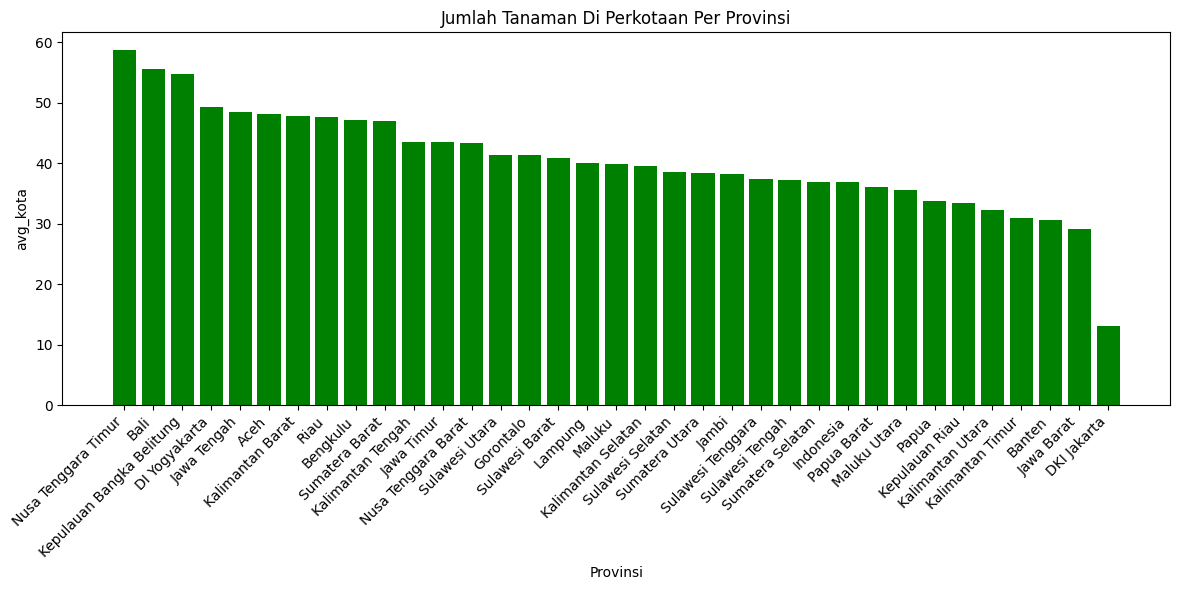

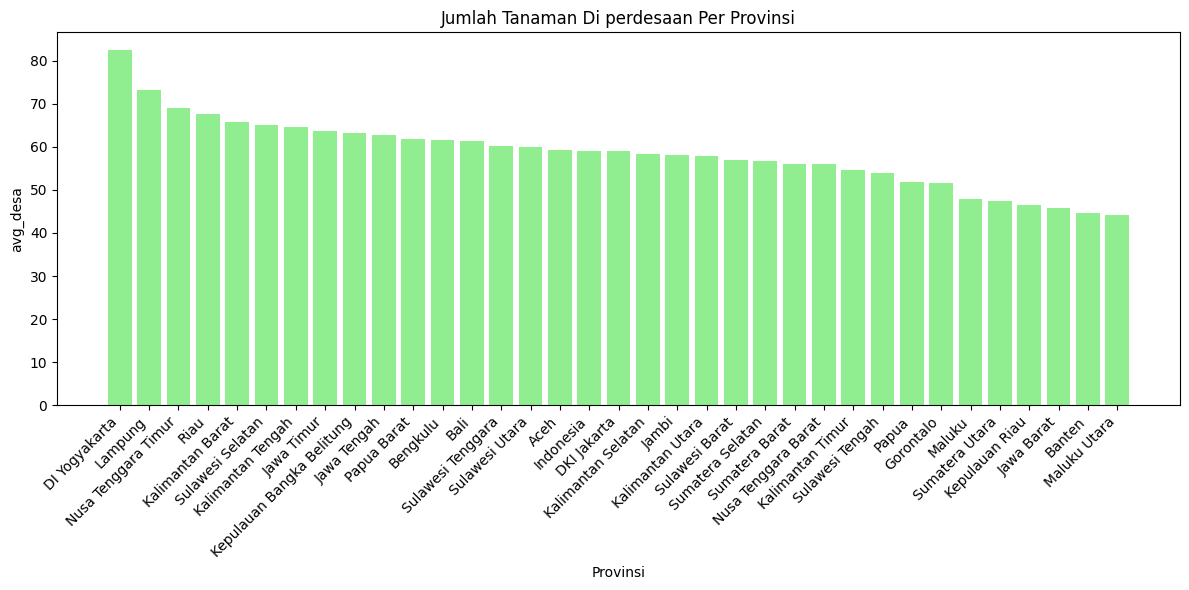

In [ ]:
# Convert Spark DataFrames to Pandas DataFrames
df_kota_pd = rank_kota.toPandas()
df_desa_pd = rank_desa.toPandas()

# Plotting the bar chart for rank_kota
plt.figure(figsize=(12, 6))
plt.bar(df_kota_pd['provinsi'], df_kota_pd['avg_kota'], color='green')
plt.title('Jumlah Tanaman Di Perkotaan Per Provinsi')
plt.xlabel('Provinsi')
plt.ylabel('avg_kota')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the bar chart for rank_desa
plt.figure(figsize=(12, 6))
plt.bar(df_desa_pd['provinsi'], df_desa_pd['avg_desa'], color='lightgreen')
plt.title('Jumlah Tanaman Di perdesaan Per Provinsi')
plt.xlabel('Provinsi')
plt.ylabel('avg_desa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df_kota_pd['provinsi'] = pd.Categorical(df_kota_pd['provinsi'])
df_kota_pd['color'] = df_kota_pd['provinsi'].cat.codes

# Create a parallel coordinates plot
fig = px.parallel_coordinates(df_kota_pd, color="prediction", labels={"provinsi": "Provinsi", "prediction": "Prediction", "features": "Features"})

# Show the plot
fig.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (3) th

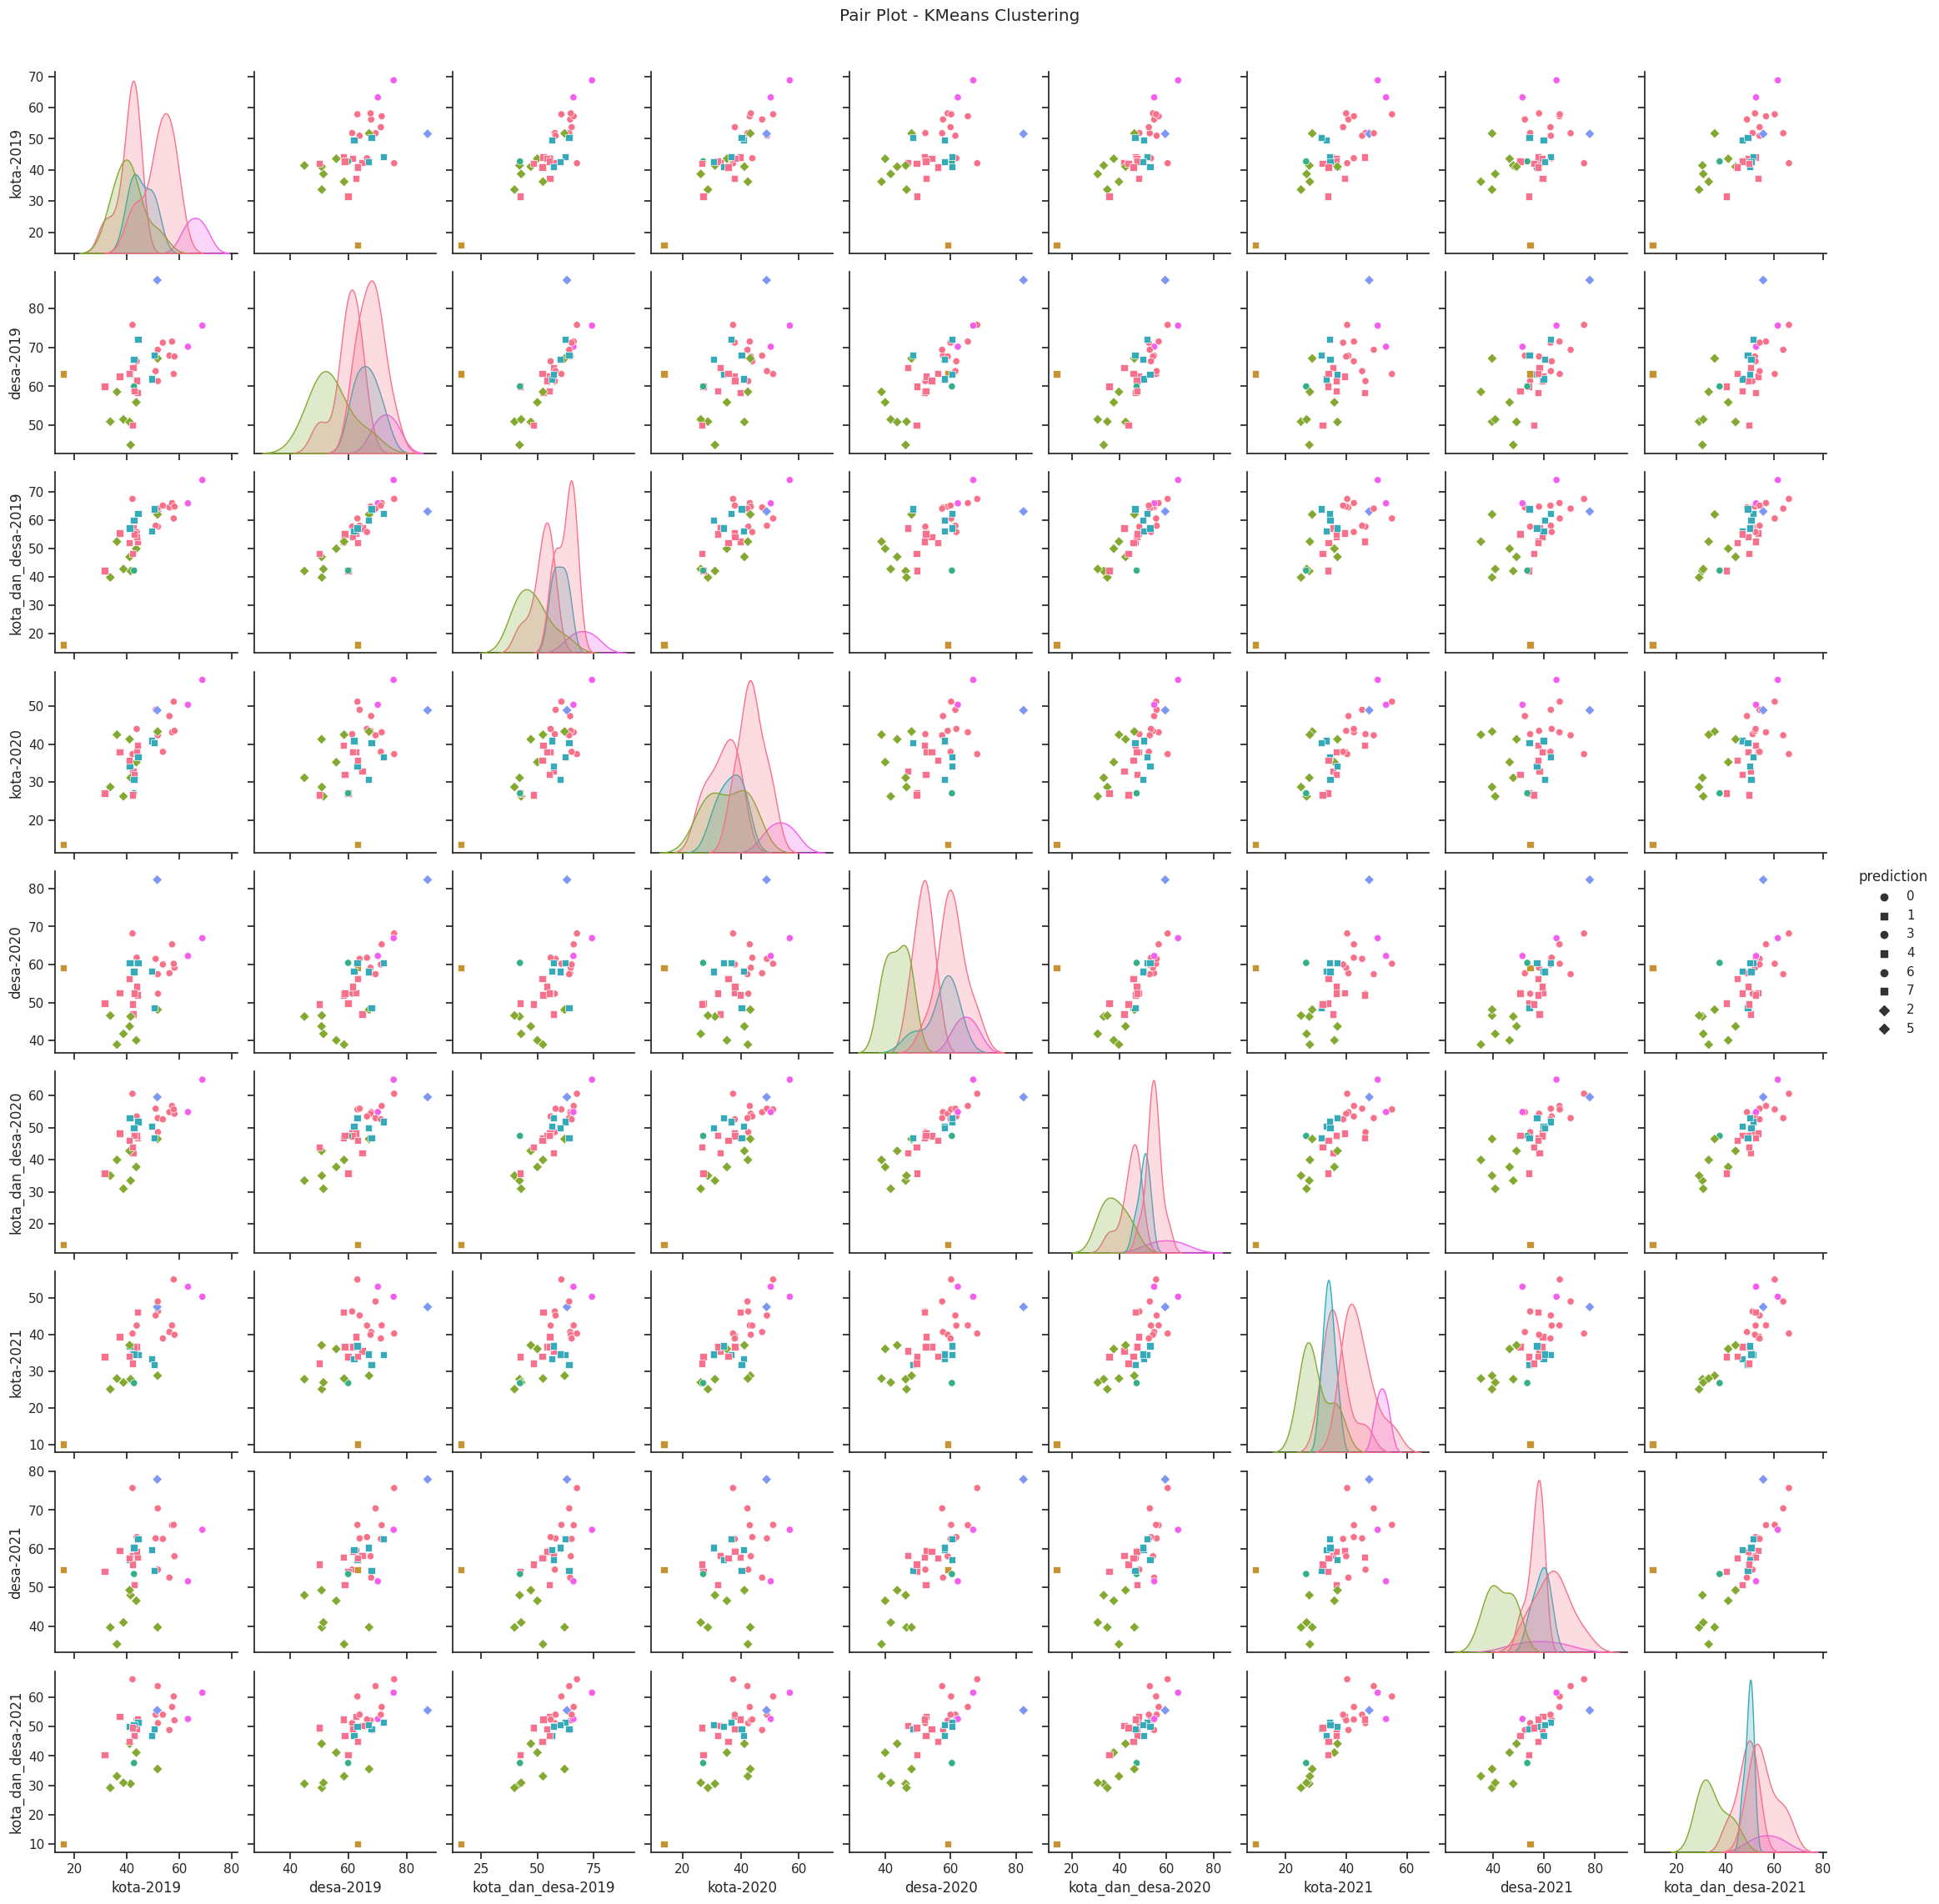

In [ ]:
df_kota_pd = predictions.select("provinsi", "prediction", *selected_columns).toPandas()

# Create a pair plot
sns.set(style="ticks")
sns.pairplot(df_kota_pd, hue="prediction", palette="husl", markers=["o", "s", "D"], diag_kind="kde")
plt.suptitle('Pair Plot - KMeans Clustering', y=1.02)
plt.show()

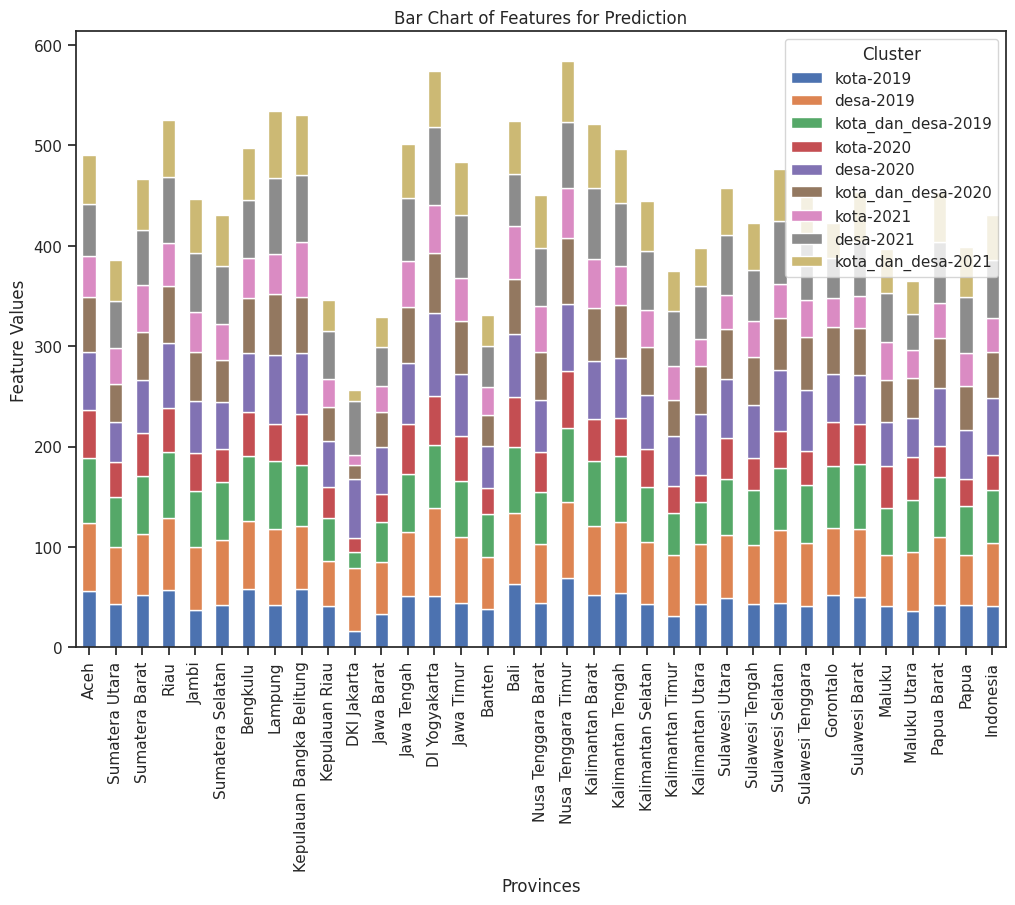

In [ ]:
df_kota_pd = predictions.toPandas()

# Set the 'provinsi' column as the index
df_kota_pd.set_index('provinsi', inplace=True)

# Plot a bar chart for all years
df_kota_pd[selected_columns].plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Bar Chart of Features for Prediction')
plt.xlabel('Provinces')
plt.ylabel('Feature Values')
plt.legend(title='Cluster')
plt.show()

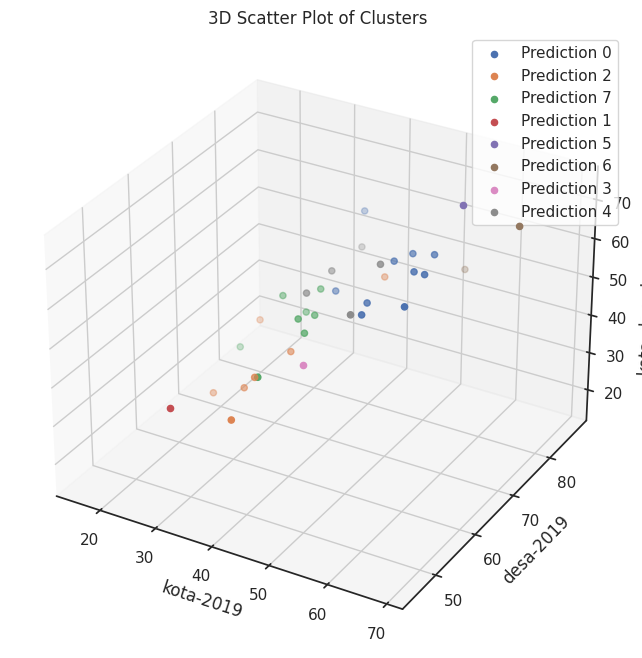

In [ ]:
df_kota_pd = predictions.select("provinsi", *selected_columns, "prediction").toPandas()

# Plot a 3D scatter plot for selected features
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for predictions in df_kota_pd['prediction'].unique():
    cluster_data = df_kota_pd[df_kota_pd['prediction'] == predictions]
    ax.scatter(cluster_data[selected_columns[0]], cluster_data[selected_columns[1]], cluster_data[selected_columns[2]], label=f'Prediction {predictions}')

ax.set_xlabel(selected_columns[0])
ax.set_ylabel(selected_columns[1])
ax.set_zlabel(selected_columns[2])
ax.set_title('3D Scatter Plot of Clusters')

# Add a legend
ax.legend()

plt.show()